In [94]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
# NOTE: It's actually best practice to use both jax.numpy (`jnp`) and regular numpy (`np`), as `np` operations are
# typically much faster than their `jnp` counterparts (at least before `jax.jit`-ing) whenever JAX-specific magic
# (automatic differentiation, vectorization, etc.) is not required. For this problem, however, since this may be your
# first experience with JAX we encourage you to use `jnp` for everything unless you know what you're doing.
# import numpy as np

from jax.experimental.ode import odeint

In [99]:
time_penalty = 0.25  # Denoted λ in the problem writeup.
initial_state = jnp.array([0., 0., jnp.pi / 2])
target_state = jnp.array([5., 5., jnp.pi / 2])


def dynamics(state, control):
    """Implements the continuous-time dynamics of a unicycle.
    Args:
        state: An array of shape (3,) containing the pose (x, y, θ) of the unicycle.
        control: An array of shape (2,) containing the linear/angular velocity controls (v, ω).
    Returns:
        The time derivative of the state. Make sure to return this as a `jnp.array`!
    """
    x, y, θ = state
    v, ω = control
    return jnp.array([v*jnp.cos(θ), v*jnp.sin(θ), ω])


def hamiltonian(state, costate, control):
    """Computes the Hamiltonian as a function of the state, costate, and control.
    Args:
        state: An array of shape (3,) containing the pose (x, y, θ) of the unicycle.
        costate: An array of shape (3,) containing the costate variables (p_x, p_y, p_θ).
        control: An array of shape (2,) containing the linear/angular velocity controls (v, ω).
    Returns:
        The scalar value of the Hamiltonian.
    """
    g = time_penalty + jnp.sum(control**2)
    f = dynamics(state, control)
    H = g + costate@f
    return H


def optimal_control(state, costate):
    """Computes the optimal control as a function of the state and costate.
    Args:
        state: An array of shape (3,) containing the pose (x, y, θ) of the unicycle.
        costate: An array of shape (3,) containing the costate variables (p_x, p_y, p_θ).
    Returns:
        An array of shape (2,) containing the optimal controls (v, ω). Make sure to return this as a `jnp.array`!
    """
    x, y, θ = state
    px, py, p_θ = costate
    v_star = -(px/2)*jnp.cos(θ)-(py/2)*jnp.sin(θ)
    ω_star = -p_θ/2
    return jnp.array([v_star,ω_star])


def shooting_ode(state_costate, t):
    """Implements the ODE that the optimal state and costate must obey.
    Args:
        state_costate: A tuple of arrays (state, costate) where
            state: An array of shape (3,) containing the pose (x, y, θ) of the unicycle.
            costate: An array of shape (3,) containing the costate variables (p_x, p_y, p_θ).
        t: Time (required for use with an ode solver; can be ignored here).
    Returns:
        A tuple of arrays (dstate_dt, dcostate_dt), the time derivatives of the state and costate. 
    """
    state, costate = state_costate
    dH_dx, dH_dp = jax.grad(hamiltonian, (0, 1))(state, costate, optimal_control(state, costate))
    # HINT: There's very little left to do in this function.
    return (dH_dp, -dH_dx)


def state_and_costate_trajectories(initial_costate_and_final_time):
    """Propagates the ODE that defines the shooting method.
    Args:
        initial_costate_and_final_time: An array of shape (4,) containing (p_x(0), p_y(0), p_θ(0), t_f).
    Returns:
        A tuple of arrays (times, (states, costates)) where
            times: An array of shape (N,) containing a sequence of time points spanning [0, t_f].
            states: An array of shape (N, 3) containing the states at `times`.
            controls: An array of shape (N, 3) containing the controls at `times`.
    """
    initial_costate = initial_costate_and_final_time[:-1]
    final_time = initial_costate_and_final_time[-1]
    times = jnp.linspace(0, final_time, 20)
    return times, odeint(shooting_ode, (initial_state, initial_costate), times)


def shooting_residual(initial_costate_and_final_time):
    """Computes the residual error for the shooting method.
    Args:
        initial_costate_and_final_time: An array of shape (4,) containing (p_x(0), p_y(0), p_θ(0), t_f).
    Returns:
        The quantities we wish to drive to 0 through appropriate selection of `initial_costate_and_final_time`.
        This should be an array of shape (4,) (corresponding to 4 equations for 4 unknowns).
        Make sure to return this as a `jnp.array`!
    """
    times, (states, costates) = state_and_costate_trajectories(initial_costate_and_final_time)
    state_f = states[-1,:]
    costate_f = costates[-1,:]

    H = hamiltonian(state_f, costate_f, optimal_control(state_f, costate_f))

    return jnp.hstack((state_f-target_state,H))


# Uncomment the next line for speedier runtime (post-compilation), but a harder time debugging.
#@jax.jit
def newton_step(initial_costate_and_final_time):
    """Implements a step of Newton's method for finding zeros of `shooting_residual`.
    Args:
        initial_costate_and_final_time: An array of shape (4,) containing (p_x(0), p_y(0), p_θ(0), t_f).
    Returns:
        An improved `initial_costate_and_final_time`; the next iterate in Newton's method.
    """
    # Consider using `jnp.linalg.solve` and `jax.jacobian` to implement this as a one-liner.
    # https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.linalg.solve.html.
    # https://jax.readthedocs.io/en/latest/_autosummary/jax.jacrev.html.
    def f(x):
      return shooting_residual(x)
    jacobian = jax.jacrev(f)(initial_costate_and_final_time)
    diff = jnp.linalg.solve(jacobian, f(initial_costate_and_final_time))
    return initial_costate_and_final_time - diff


def shooting_method(initial_costate_and_final_time_guess):
    """Implements an indirect simple shooting method for solving the optimal control problem.
    Args:
        initial_costate_and_final_time_guess: An initial guess for `initial_costate_and_final_time`.
    Returns:
        An optimized `initial_costate_and_final_time`.
    """
    error = float('inf')
    eps = 1e-6
    for _ in range(1000):
      if error < eps:
        break
      next_iter = newton_step(initial_costate_and_final_time_guess)
      error = jnp.linalg.norm(next_iter-initial_costate_and_final_time_guess)
      initial_costate_and_final_time_guess = next_iter
    return initial_costate_and_final_time_guess

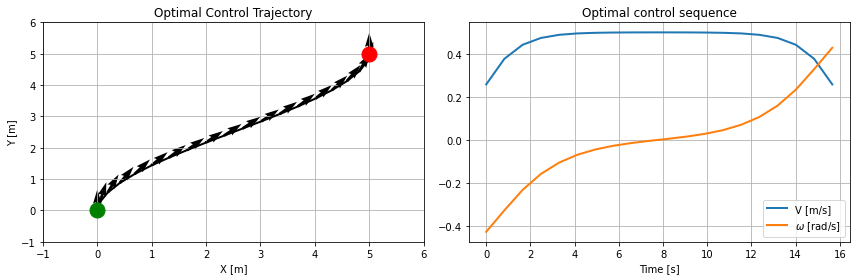

In [100]:
initial_costate_and_final_time_guess = jnp.array([-1.,-1.,1.,20.])
times, (states, costates) = state_and_costate_trajectories(shooting_method(initial_costate_and_final_time_guess))
controls = jax.vmap(optimal_control)(states, costates)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(states[:, 0], states[:, 1], 'k-', linewidth=2)
plt.quiver(states[:, 0], states[:, 1], jnp.cos(states[:, 2]), jnp.sin(states[:, 2]))
plt.grid(True)
plt.plot(0, 0, 'go', markerfacecolor='green', markersize=15)
plt.plot(5, 5, 'ro', markerfacecolor='red', markersize=15)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.axis([-1, 6, -1, 6])
plt.title('Optimal Control Trajectory')

plt.subplot(1, 2, 2)
plt.plot(times, controls[:, 0], linewidth=2)
plt.plot(times, controls[:, 1], linewidth=2)
plt.grid(True)
plt.xlabel('Time [s]')
plt.legend(['V [m/s]', '$\omega$ [rad/s]'], loc='best')
plt.title('Optimal control sequence')
plt.tight_layout()
plt.savefig('p5_unicycle_single_shooting.png')
plt.show()